In [1]:
from models import  vae_EUCL, vae_HYP, ResNetvae_EUCL
import geoopt
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from hypmath import poincareball
from hypmath import metrics
import pandas as pd 
from tqdm import tqdm
import time
from torch.utils.data import SubsetRandomSampler

#Disable Debugging APIs
torch.autograd.set_detect_anomaly(False)
torch.autograd.profiler.profile(False)
torch.autograd.profiler.emit_nvtx(False)

#cuDNN Autotuner
torch.backends.cudnn.benchmark = True

#CUDA check

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
image_size = 64
transform = transforms.Compose([
                        transforms.Resize(image_size),
                        transforms.CenterCrop(image_size),
                        transforms.ToTensor(),
                        #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                        ])


trainset = datasets.ImageFolder('data', transform=transform)
num_data = list(range(0, 102400))
trainset_1 = torch.utils.data.Subset(trainset, num_data)
trainloader = torch.utils.data.DataLoader(trainset_1, batch_size=64, 
                                         num_workers=1, pin_memory=True, shuffle=True)
# dataiter = iter(trainloader)
# images, _ = dataiter.next()
# images.shape

In [4]:
### Training function

reconstruction_function = nn.MSELoss(reduction='sum')
#reconstruction_function.size_average = False
def loss_function(recon_x, x, mu, logvar):
    BCE = reconstruction_function(recon_x, x)

    # https://arxiv.org/abs/1312.6114 (Appendix B)
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD_element = mu.pow(2).add_(logvar.exp()).mul_(-1).add_(1).add_(logvar)
    KLD = torch.sum(KLD_element).mul_(-0.5)

    return BCE + KLD

def train_epoch(vae, dataloader, optimizer):
    # Set train mode for both the encoder and the decoder
    vae.train()
    train_loss = 0.0
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for x, _ in dataloader: 
        # Move tensor to the proper device
        x = x.to(device)
        for param in vae.parameters():
            param.grad = None

        recon_x, mu, logvar = vae(x)
        # Evaluate loss
        #loss = ((x - x_hat)**2).sum() + (vae.encoder.kl)
        #loss = BCE + (vae.encoder.kl)
        loss = loss_function(recon_x, x, mu, logvar)

        # Backward pass
        #optimizer.zero_grad()   
        loss.backward()
        optimizer.step()
        # Print batch loss
        print('\t partial train loss (single batch): %f' % (loss.item()))
        train_loss+=loss.item()

    return train_loss / len(dataloader.dataset)

In [5]:
### Testing function
def test_epoch(vae, dataloader):
    # Set evaluation mode for encoder and decoder
    vae.eval()
    val_loss = 0.0
    with torch.no_grad(): # No need to track the gradients
        for x, _ in dataloader:
            # Move tensor to the proper device
            # x = x.to(device)
            # Encode data
            encoded_data = vae.encoder(x)
            # Decode data
            x_hat = vae(x)
            print(x.shape)
            loss = ((x - x_hat)**2).sum() 
            #+ vae.encoder.kl
            val_loss += loss.item()

    return val_loss / len(dataloader.dataset)

In [6]:
def plot_ae_outputs(encoder,decoder,n):
    plt.figure(figsize=(10,4.5))
    for i in range(n):
      ax = plt.subplot(2,n,i+1)
      img = trainset_1[i][0].unsqueeze(0)
      img = img.to(device)
      #img = next(iter(trainloader))
      encoder.eval()
      decoder.eval()
      with torch.no_grad():
        z, _ , _ = encoder(img)
        rec_img  = decoder(z)
      plt.imshow(img.cpu().squeeze().permute(1, 2, 0).numpy())
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
        ax.set_title('Original images')
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow((rec_img.cpu().squeeze().permute(1, 2, 0).numpy()))  
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
         ax.set_title('Reconstructed images')
    plt.show()   

VariationalAutoencoder(
  (encoder): VariationalEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (batch1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (batch2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (batch3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv4): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (batch4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv5): Conv2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (batch5): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (lin

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


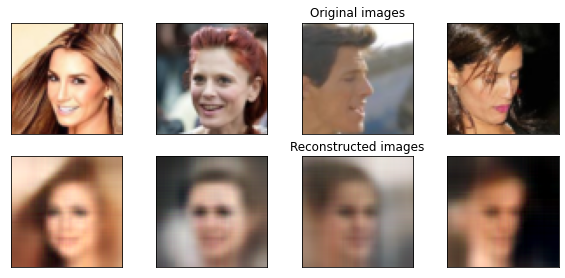

	 partial train loss (single batch): 14615.997070
	 partial train loss (single batch): 14504.837891
	 partial train loss (single batch): 15039.421875
	 partial train loss (single batch): 14966.957031
	 partial train loss (single batch): 15870.996094
	 partial train loss (single batch): 14201.922852
	 partial train loss (single batch): 16460.330078
	 partial train loss (single batch): 14073.880859
	 partial train loss (single batch): 15014.075195
	 partial train loss (single batch): 14721.680664
	 partial train loss (single batch): 14406.292969
	 partial train loss (single batch): 14966.018555
	 partial train loss (single batch): 14527.934570
	 partial train loss (single batch): 15235.160156
	 partial train loss (single batch): 14757.985352
	 partial train loss (single batch): 14007.251953
	 partial train loss (single batch): 15088.891602
	 partial train loss (single batch): 15277.185547
	 partial train loss (single batch): 16754.121094
	 partial train loss (single batch): 13762.038086


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


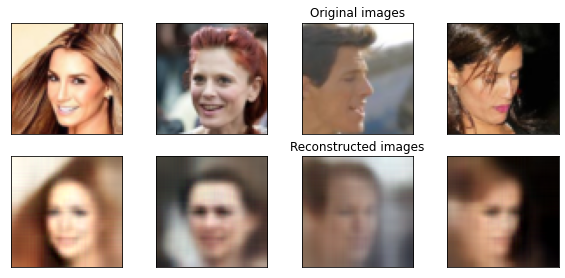

	 partial train loss (single batch): 14397.914062
	 partial train loss (single batch): 12913.623047
	 partial train loss (single batch): 12827.527344
	 partial train loss (single batch): 13332.183594
	 partial train loss (single batch): 14309.044922
	 partial train loss (single batch): 13736.589844
	 partial train loss (single batch): 12566.992188
	 partial train loss (single batch): 14084.765625
	 partial train loss (single batch): 12428.979492
	 partial train loss (single batch): 12830.885742
	 partial train loss (single batch): 12724.360352
	 partial train loss (single batch): 12607.322266
	 partial train loss (single batch): 13168.300781
	 partial train loss (single batch): 13831.875000
	 partial train loss (single batch): 13740.666992
	 partial train loss (single batch): 12567.014648
	 partial train loss (single batch): 13722.222656
	 partial train loss (single batch): 13787.685547
	 partial train loss (single batch): 13639.514648
	 partial train loss (single batch): 14235.188477


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


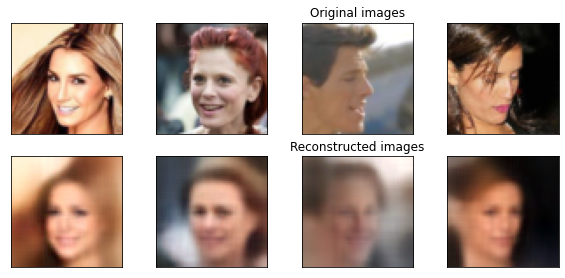

	 partial train loss (single batch): 12751.257812
	 partial train loss (single batch): 13527.677734
	 partial train loss (single batch): 13715.208984
	 partial train loss (single batch): 13730.030273
	 partial train loss (single batch): 12604.903320
	 partial train loss (single batch): 13522.656250
	 partial train loss (single batch): 13457.926758
	 partial train loss (single batch): 13843.500000
	 partial train loss (single batch): 13625.057617
	 partial train loss (single batch): 12880.945312
	 partial train loss (single batch): 13921.534180
	 partial train loss (single batch): 12844.146484
	 partial train loss (single batch): 12323.847656
	 partial train loss (single batch): 13183.868164
	 partial train loss (single batch): 14291.517578
	 partial train loss (single batch): 13360.854492
	 partial train loss (single batch): 13000.560547
	 partial train loss (single batch): 13490.468750
	 partial train loss (single batch): 12908.249023
	 partial train loss (single batch): 12493.002930


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


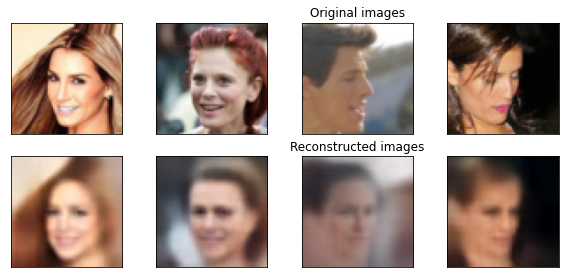

	 partial train loss (single batch): 12060.720703
	 partial train loss (single batch): 13174.747070
	 partial train loss (single batch): 13044.038086
	 partial train loss (single batch): 12443.570312
	 partial train loss (single batch): 12603.838867
	 partial train loss (single batch): 12478.655273
	 partial train loss (single batch): 13073.958984
	 partial train loss (single batch): 12269.133789
	 partial train loss (single batch): 13248.753906
	 partial train loss (single batch): 12464.394531
	 partial train loss (single batch): 12320.983398
	 partial train loss (single batch): 13179.859375
	 partial train loss (single batch): 12053.006836
	 partial train loss (single batch): 15292.586914
	 partial train loss (single batch): 11846.267578
	 partial train loss (single batch): 13724.025391
	 partial train loss (single batch): 12969.428711
	 partial train loss (single batch): 12689.800781
	 partial train loss (single batch): 12522.429688
	 partial train loss (single batch): 12525.199219


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


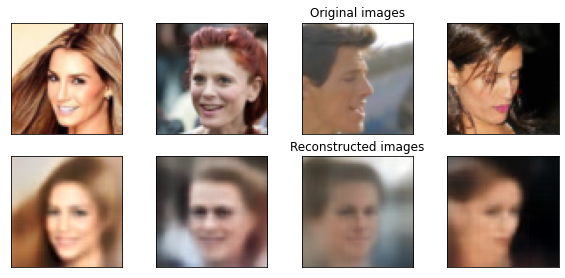

In [7]:
model = vae_EUCL.VariationalAutoencoder(nc=3, ndf=64, ngf=64, latent_dims=100, device=device)
model.to(device)
print(model)
epochs = 5
learning_rate = 5e-4

#optim = geoopt.optim.RiemannianAdam(model.parameters(), lr=learning_rate)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#Training loop
for epoch in range(epochs):
   train_loss = train_epoch(model, trainloader, optimizer)
   print('\n EPOCH {}/{} \t train loss {:.3f}'.format(epoch + 1, epochs, train_loss))
   plot_ae_outputs(model.encoder, model.decoder,n=4)


# save model checkpoint
torch.save({
            'epoch': epochs,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss_function,
            }, 'outputs/model.pth')

#Resuming Model Training

Previously trained model weights state_dict loaded...
Previously trained optimizer state_dict loaded...
Trained model loss function loaded...
Previously trained for 3 number of epochs...
Train for 3 more epochs...
	 partial train loss (single batch): 11724.625000
	 partial train loss (single batch): 11957.101562
	 partial train loss (single batch): 12227.484375
	 partial train loss (single batch): 12439.525391
	 partial train loss (single batch): 12620.724609
	 partial train loss (single batch): 11574.592773
	 partial train loss (single batch): 11857.127930
	 partial train loss (single batch): 12021.842773
	 partial train loss (single batch): 11363.573242
	 partial train loss (single batch): 11830.859375
	 partial train loss (single batch): 12242.429688
	 partial train loss (single batch): 12345.312500
	 partial train loss (single batch): 12979.529297
	 partial train loss (single batch): 12066.226562
	 partial train loss (single batch): 11503.083984
	 partial train loss (single batch):

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 EPOCH 1/3 	 train loss 181.967


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


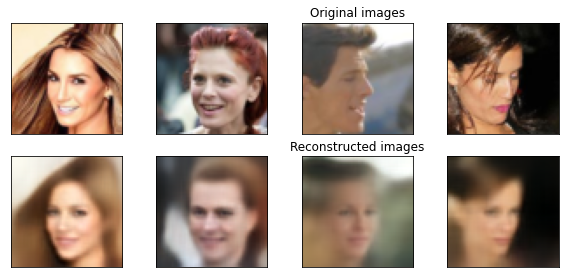

	 partial train loss (single batch): 11870.232422
	 partial train loss (single batch): 11346.730469
	 partial train loss (single batch): 11618.518555
	 partial train loss (single batch): 11560.382812
	 partial train loss (single batch): 12272.460938
	 partial train loss (single batch): 11948.964844
	 partial train loss (single batch): 12288.097656
	 partial train loss (single batch): 11067.062500
	 partial train loss (single batch): 11766.259766
	 partial train loss (single batch): 12088.509766
	 partial train loss (single batch): 12093.239258
	 partial train loss (single batch): 11564.250000
	 partial train loss (single batch): 11084.185547
	 partial train loss (single batch): 11738.723633
	 partial train loss (single batch): 11721.571289
	 partial train loss (single batch): 11978.279297
	 partial train loss (single batch): 11839.181641
	 partial train loss (single batch): 10765.844727
	 partial train loss (single batch): 12322.392578
	 partial train loss (single batch): 12070.005859


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


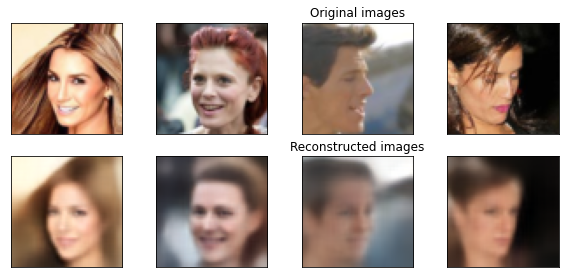

	 partial train loss (single batch): 11822.010742
	 partial train loss (single batch): 11313.035156
	 partial train loss (single batch): 11582.600586
	 partial train loss (single batch): 11791.003906
	 partial train loss (single batch): 11821.269531
	 partial train loss (single batch): 11195.167969
	 partial train loss (single batch): 11348.490234
	 partial train loss (single batch): 10308.688477
	 partial train loss (single batch): 12338.649414
	 partial train loss (single batch): 11408.234375
	 partial train loss (single batch): 11255.955078
	 partial train loss (single batch): 12153.547852
	 partial train loss (single batch): 11335.225586
	 partial train loss (single batch): 11190.716797
	 partial train loss (single batch): 12431.098633
	 partial train loss (single batch): 11108.340820
	 partial train loss (single batch): 11328.206055
	 partial train loss (single batch): 12261.068359
	 partial train loss (single batch): 11210.314453
	 partial train loss (single batch): 10742.143555


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


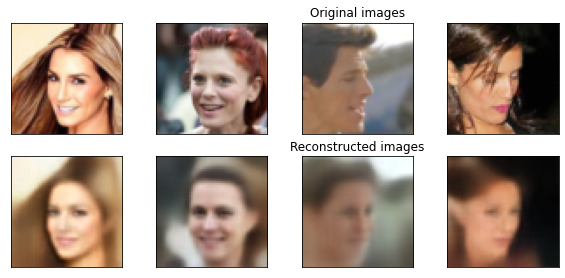

In [13]:
# load the trained model
model_resume = model.to(device) # initilize the model
# initialize optimizer  before loading optimizer state_dict
epochs_new = 5
learning_rate_new = 5e-4
optimizer_new = optim.Adam(model_resume.parameters(), lr=learning_rate_new)


checkpoint = torch.load('outputs/model.pth')

# load model weights state_dict
model.load_state_dict(checkpoint['model_state_dict'])
print('Previously trained model weights state_dict loaded...')

# load trained optimizer state_dict
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
print('Previously trained optimizer state_dict loaded...')

epochs = checkpoint['epoch']
# load the criterion
loss_function = checkpoint['loss']
print('Trained model loss function loaded...')
print(f"Previously trained for {epochs} number of epochs...")

# train for more epochs
epochs = epochs_new
print(f"Train for {epochs} more epochs...")


#New Training loop
for epoch in range(epochs):
   train_loss = train_epoch(model_resume, trainloader, optimizer_new)
   print('\n EPOCH {}/{} \t train loss {:.3f}'.format(epoch + 1, epochs, train_loss))
   plot_ae_outputs(model.encoder, model.decoder,n=4)

# save model checkpoint
torch.save({
            'epoch': epochs,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss_function,
            }, 'outputs/model.pth')

#5,3,3,3,5

In [9]:
# encoded_samples = []
# for sample in tqdm(trainset_1):
#     img = sample[0].unsqueeze(0)
#     label = sample[1]
#     # Encode image
#     model.eval()
#     with torch.no_grad():
#         encoded_img  = model.encoder(img)
#     # Append to list
#     encoded_img = encoded_img.flatten().cpu().numpy()
#     encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
#     encoded_sample['label'] = label
#     encoded_samples.append(encoded_sample)
    
# encoded_samples = pd.DataFrame(encoded_samples)



# from sklearn.manifold import TSNE
# from sklearn.metrics import davies_bouldin_score
# from sklearn.metrics import calinski_harabasz_score
# from sklearn.metrics import silhouette_score
# import plotly.express as px

# #Davies-Bouldin Index
# db_index = davies_bouldin_score(encoded_samples, encoded_samples.label)
# print(db_index)

# #Calinski-Harabasz Index
# ch_score = calinski_harabasz_score(encoded_samples, encoded_samples.label)
# print(ch_score)

# # #Silhouette Coefficient
# # s_coeff = silhouette_score(encoded_samples, encoded_samples.label,  metric=metrics.PoincareDistance)
# # print(s_coeff)

# px.scatter(encoded_samples, x='Enc. Variable 0', y='Enc. Variable 1', color=encoded_samples.label.astype(str), opacity=0.7)

In [10]:
# tsne = TSNE(n_components=2)
# tsne_results = tsne.fit_transform(encoded_samples.drop(['label'],axis=1))

# fig = px.scatter(tsne_results, x=0, y=1, color=encoded_samples.label.astype(str),labels={'0': 'tsne-2d-one', '1': 'tsne-2d-two'})

# # #Davies-Bouldin Index
# # db_index = davies_bouldin_score(tsne_results, encoded_samples.label)
# # print(db_index)

# # #Calinski-Harabasz Index
# # ch_score = calinski_harabasz_score(tsne_results, encoded_samples.label)
# # print(ch_score)

# # #Silhouette Coefficient
# # s_coeff = silhouette_score(tsne_results, encoded_samples.label)
# # print(s_coeff)
# fig.show()